<a href="https://colab.research.google.com/github/smsharma/iaifi-summer-school-tutorials/blob/main/01_mcmc_and_vi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: An introduction to probabilistic programming with Jax and NumPyro 

**IAIFI Summer School 2022 Tutorial for _Machine Learning for Beyond-the-Standard-Model Physics_**

**Siddharth Mishra-Sharma** ([smsharma@mit.edu](mailto:smsharma@mit.edu))


>[An introduction to probabilistic programming with Jax and NumPyro](#scrollTo=UiN1xaKf8IjW)

>>[1. Introduction](#scrollTo=wQPg4LHv8Ija)

>>>[1.1 Probabilistic modeling as storytelling](#scrollTo=GtxxXu1j8Ijb)

>>>[1.2. Probabilistic programming languages (PPLs)](#scrollTo=bn3SWQ6-8Ije)

>>[2. The dataset and noise model / likelihood](#scrollTo=0oS1h9f18Ijf)

>>[3. Warmup: point-estimate and posterior grid](#scrollTo=-Fzm07lC8Ijj)

>>>[3.1. Weighted least squares](#scrollTo=k1GK0ytySa4h)

>>>[3.2. With vmap + jit ⚡️](#scrollTo=FJNzofzbOT5C)

>>>[3.3. The posterior distribution: grid](#scrollTo=HJBQ1smtOrxD)

>>[4. Markov Chain Monte Carlo](#scrollTo=ir6Zz7ik8Ijn)

>>[5. Differentiable probabilistic programming approaches with NumPyro](#scrollTo=NA5jx5oD8Ijp)

>>>>[5.1. Defining the model: probabilistic graphical models (PGMs)](#scrollTo=wV_U_Vqj8Ijp)

>>>>[5.2. Inference with Hamiltonian Monte Carlo (HMC)](#scrollTo=G0H_RnJq8Ijr)

>>>>[5.3. Inference with Stochastic Variational Inference (SVI)](#scrollTo=XXSPc-1G8Ijs)



## 1.&nbsp;Introduction <a name="introduction"></a>

The main goal of these tutorials is to gently introduce recipes to connect theoretical models to observations. Specifically, we'll discuss:
- The paradigm of probabilistic programming and using it to define probabilistic models connecting physical theories to observations;
- Using the probabilistic programming language (PPL) NumPyro as well as the Jax framework (on which it is based) to efficiently implement differentiable models and perform inference on them;
- Different inference strategies made possible by using differentiable models, including Hamiltonian Monte Carlo and Variational Inference.

We will do so using a simple example from cosmology: inferring the Hubble constant $H_0$ and other cosmological parameters from measurements of supernova magnitudes.

### 1.1&nbsp;Probabilistic modeling as storytelling

- One way to look at defining probabilistic models: telling a story about how you think your data came about
- Many scientific observations of interest can be described in terms of simulators
- Simulators execute a series of stochastic steps to produce a realization of the dataset of interest---**simulators are probabilistic programs**

<img src="https://raw.githubusercontent.com/smsharma/smsharma/master/lhc.png#" alt="LHC Schematic" width="800"/>

$$\theta \sim p(\theta)$$
$$\mathrm{parton} \sim p(\mathrm{parton}\mid\theta)$$
$$\mathrm{shower} \sim p(\mathrm{shower}\mid\mathrm{parton})$$
$$\mathrm{detector} \sim p(\mathrm{detector}\mid\mathrm{shower})$$
$$x \sim p(x\mid \mathrm{detector})$$

After writing our forward model as a probabilistic program, we can use inference algorithms to 'invert' the process and get the Bayesian posterior $p(\theta\mid x)$ for a given observation

### 1.2.&nbsp;Probabilistic programming languages (PPLs)

- Probabilistic programming languages (PPLs) realize this paradigm by treating (random) variables and distributions as first-class objects, allowing us to
    - Compose probabilistic models in terms of distributions of random variables, and
    - Perform inference on models by them conditioning on observations.

A biased sample of PPLs, with different design philosophies and inference engines:
- [Pyro](https://pyro.ai/)/[NumPyro](https://num.pyro.ai/en/stable/): based on PyTorch/Jax with strengths in variational inference and MCMC respectively. We will use NumPyro in this tutorial, additionally showcasing some of the nice features of Jax.
- [PyMC3](https://docs.pymc.io/en/v3/): a solid general-purpose PPL in Python
- [Turing.jl](https://turing.ml/stable/): based on Julia
- [Tensorflow Probability](https://www.tensorflow.org/probability): based on Tensorflow

Being based on differentiable framework, they make it easy to use gradient-based optimization for inference.

In [1]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

color_default = 'firebrick'

from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
! pip install emcee corner numpyro tqdm
! pip install --upgrade daft

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 1.8 MB/s 
     |████████████████████████████████| 291 kB 8.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: daft
    Found existing installation: daft 0.0.4
    Uninstalling daft-0.0.4:
      Successfully uninstalled daft-0.0.4


## 2.&nbsp;The dataset and noise model / likelihood

We will use the [Supernova Cosmology Project "Union" compilation](https://supernova.lbl.gov/Union/) of Type Ia supernova magnitudes. Let's download, load and plot it.

TODO: Add more theory here.

In [3]:
import urllib.request

# Download the SN data file
url = 'https://supernova.lbl.gov/union/figures/SCPUnion2.1_mu_vs_z.txt'
os.makedirs("./data", exist_ok=True)
urllib.request.urlretrieve(url, './data/SCPUnion2.1_mu_vs_z.txt')

('./data/SCPUnion2.1_mu_vs_z.txt', <http.client.HTTPMessage at 0x7f7eefac5050>)

In [4]:
data = np.genfromtxt('./data/SCPUnion2.1_mu_vs_z.txt')

zs = data.T[1]  # Redshift
mm = data.T[2]  # Difference between apparent and absolute magnitude (distance modulus)
dm = data.T[3]  # Its uncertainty

c = 3e5  # Speed of light

Text(0.5, 1.0, 'SCP Union2.1 dataset')

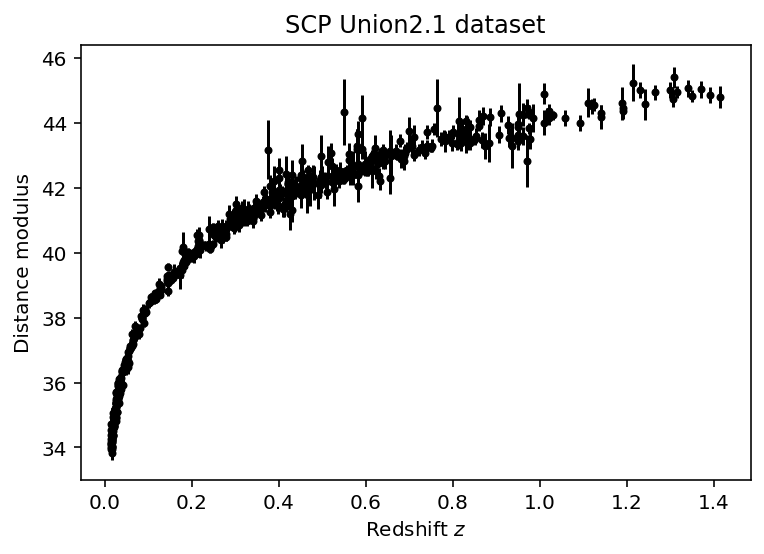

In [5]:
plt.errorbar(zs, mm, yerr=dm, marker='.', ls='None', color='k')

plt.xlabel(r"Redshift $z$")
plt.ylabel(r"Distance modulus")
plt.title(r"SCP Union2.1 dataset")

In [6]:
print("Dataset consists of {} data points".format(len(mm)))

Dataset consists of 580 data points


We'll use this dataset to infer the hubble parameter $H_0$ as well as the matter density at present times $\Omega_{m,0}$.

The luminosity distance can be computed as 
$$ d_{\mathrm L} = (1 + z)\int_0^{z} \mathrm d z' \frac{c}{H(z')}$$
where for our model the Hubble constant evolves as
$$ H(z) = H_0\sqrt{\Omega_{m,0}(1 + z)^3 + \Omega_{\Lambda, 0}}.$$
where we assume $\Omega_{\Lambda, 0} = 1 - \Omega_{m,0}$ for a flat Universe. This can be easily extended to more complex models, e.g. a non-flat Universe or an evolving dark energy equation of state. Feel free to give these a shot!

Text(0.5, 1.0, 'SCP Union2.1 dataset')

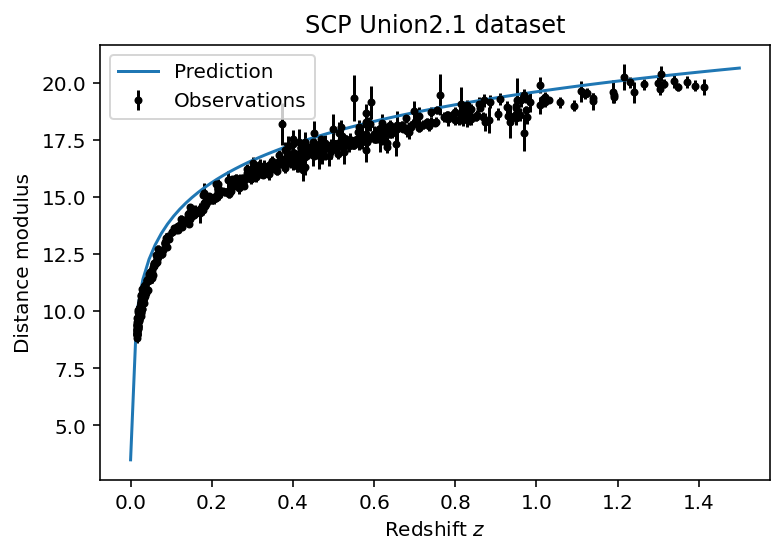

In [7]:
from scipy.integrate import quad

def H(z, H0=70., OmM=0.3, OmL=0.7):
  """ Hubble evolution
  :param H0: Hubble constant
  :param OmM: Matter density 
  :param OmL: Dark energy density 
  """
  return H0 * jnp.sqrt(OmM * (1 + z) ** 3 + OmL)

def dL(z, H0=70, OmM=0.3):
  """ Luminosity distance for flat Universe, assuming OmL = 1 - OmM
  :param z: Redshift
  :param H0: Hubble constant
  :param OmM: Matter density 
  """
  z_ary = jnp.linspace(0., z, 100)
  return jnp.trapz(c / H(z_ary, H0, OmM, 1 - OmM), z_ary) * (1 + z)

def mu(z, H0=70, OmM=0.3):
  """ Distance modulus (difference between apparent and absolute luminosity)
  :param z: Redshift
  :param H0: Hubble constant
  :param OmM: Matter density 
  """
  return jnp.log10(dL(z, H0, OmM) + 5.) * 5.

# Let's plot the predicted distance modulus over the redshift range of observation and compare with observations

z_ary = np.linspace(0, 1.5, 100)

plt.plot(z_ary, [mu(z, H0=50., OmM=0.5) for z in z_ary], label="Prediction")
plt.errorbar(zs, mm - 25, yerr=dm, marker='.', ls='None', color='k', label="Observations")

plt.legend()

plt.xlabel(r"Redshift $z$")
plt.ylabel(r"Distance modulus")
plt.title(r"SCP Union2.1 dataset")


- Our goal will be to explore different strategies for obtaining a distribution of $H_0$ and $\Omega_{m,0}$ that are compatible with the data.
- The problem here is simple enough that we don't really need anything too fancy; however, we will introduce methods that can scale to more complicated problems

We start by defining the likelihood $p(x\mid\theta)$ for the observed data $x$ and parameters $\theta$, which we take to be Gaussian in the latent distance modulus $\mu_\mathrm{pred}$,
$$
p(\mu_\mathrm{obs}\mid H_0, \Omega_{m,0}) = \mathcal N(\mu_\mathrm{pred},\sigma_{\mu_\mathrm{obs}}; \mu_\mathrm{obs}).
$$

In [8]:
def mu_pred(z_ary, H0, OmM):
  """ Predicted distance modulus over redshift array z_ary, 
      computed with list comprehension
  """
  return np.array([mu(zz, H0, OmM) for zz in z_ary])

def log_likelihood(theta, z, mu_obs, mu_err):
  """ Gaussian log-likelihood of dist. mod. given H0 and deceleration parameter q
  :param theta: Tuple of [H0, OmM]
  :param z: Redshift array of observations
  :param mu_obs: Observed dist. mod.
  :param mu_err: Std of observed dist. mod.
  """
  H0, OmM = theta
  mu = mu_pred(z, H0, OmM) + 25.
  ll = -0.5 * np.sum((mu_obs - mu) ** 2 / mu_err ** 2)
  return ll

Given a likelihood as well as a prior distribution for the parameters $p(\theta)$, the posterior $p(\theta\mid x)$ can be obtained using Bayes' rule:

$$ p(\theta\mid x) = \frac{p(x\mid\theta)\cdot p(\theta)}{p(x)}.$$

The term in the denominator on the RHS is model evidence, also known as the marginal likelihood; $p(x) = ∫ p(x\mid\theta)\,\mathrm d\theta$. This integral is often computationally intractable in high (parameter) dimensions, necessitating the approximate methods we will explore later on.

## 3.&nbsp;Warmup: point-estimate and posterior grid

### 3.1.&nbsp;Weighted least squares

We'll start with a simple weighted least squares approach using `scipy.optimize.minimize`. Use the optimizer to obtain the maximum-likelihood estimate (MLE) by minimizing the (negative) log-likelihood.

In [9]:
from scipy.optimize import minimize

In [10]:
nll = lambda *args: -log_likelihood(*args)
soln = minimize(nll, [30., 0.5], bounds=[[1., 100.],[0., 1.]], args=(zs, mm, dm))
H0_mle, OmM0_mle = soln.x

print("MLE estimates are H0 = {}, OmM = {}".format(H0_mle, OmM0_mle))

MLE estimates are H0 = 71.94844033512072, OmM = 0.2147804866407488


### 3.2.&nbsp;With vmap + jit ⚡️

The use of a list comprehension `[mu(z, ..) for z in z_ary]` in the function `mu_pred` above is clunky. We can significantly speed up our likelihood by vectorizing this operation over the redshift array. Jax makes this easy using `vmap`

In [11]:
from jax import vmap, jit

# Define a vectorized function over the first axis of the first argument (the redshift array)
mu_pred_vmap = jit(vmap(mu, in_axes=(0,None,None)))

In [12]:
def log_likelihood_vmap(theta, z, mu_obs, mu_err):
  """ Gaussian log-likelihood of dist. mod. given H0 and deceleration parameter q
  :param theta: Tuple of [H0, OmM]
  :param z: Redshift array of observations
  :param mu_obs: Observed dist. mod.
  :param mu_err: Std of observed dist. mod.
  """
  H0, OmM = theta
  mu = mu_pred_vmap(z, H0, OmM) + 25.
  ll = -0.5 * np.sum((mu_obs - mu) ** 2 / mu_err ** 2)
  return ll

Now try MLE inference again:

In [13]:
nll = lambda *args: -log_likelihood_vmap(*args)
soln = minimize(nll, [30., 0.5], bounds=[[1., 100.],[0., 1.]], args=(zs, mm, dm))
H0_mle, OmM0_mle = soln.x

print("MLE estimates are H0 = {}, OmM = {}".format(H0_mle, OmM0_mle))

MLE estimates are H0 = 71.9484397846938, OmM = 0.21478051782795915


This should be significantly faster, whether using a CPU or GPU. With Jax, we can write functions for scalar arguments and easily vectorize them with `vmap`. Let's explicitly time the two likelihood implementations.

In [14]:
%%timeit
log_likelihood([H0_mle, OmM0_mle], zs, mm, dm)

1 loop, best of 5: 924 ms per loop


In [15]:
%%timeit
log_likelihood_vmap([H0_mle, OmM0_mle], zs, mm, dm)

1000 loops, best of 5: 1.18 ms per loop


⚡️. 

### 3.3.&nbsp;The posterior distribution: grid

Now let's try computing the posterior distribution. For our low, 2-dimensional parameter space we can try to simple compute the un-normalized log-posterior on a grid. 

Let's code this up and compute it on a grid.

In [16]:
def log_post(theta, x, y, y_err):
    """ Log-posterior, un-normalized, including uniform prior contribution
    """

    H0, OmM0 = theta

    # A hacky way to specify the prior contribution, because Jax
    lp = 0.

    lp += jnp.where(H0 < 100., 0., -np.inf)
    lp += jnp.where(10 < H0, 0., -np.inf)

    lp += jnp.where(OmM0 < 1., 0., -np.inf)
    lp += jnp.where(0 < OmM0, 0., -np.inf)

    # Log-prior plus log-likelihood
    return lp + log_likelihood_vmap(theta, x, y, y_err)

We can vectorize over the parameter array:

In [17]:
log_post_vmap = jit(vmap(log_post, (0,None,None,None)))

And compute the un-normalized log-posterior on a grid.

In [18]:
# Grid size to use for the parameters
n_xy = 80

H0_ary = jnp.linspace(60., 80., n_xy)
OmM0_ary = jnp.linspace(0.1, 0.4, n_xy)

# Get grid of parameters
H0_grid, OmM0_grid = jnp.meshgrid(H0_ary, OmM0_ary)
H0OmM0_grid = jnp.stack((H0_grid, OmM0_grid))  

# Comput log-posteriors over grid
log_post_grid = log_post_vmap(H0OmM0_grid.reshape(-1, n_xy * n_xy).T, zs, mm, dm)

# Normalize the posterior
post_grid = jnp.exp(log_post_grid.reshape(n_xy,  n_xy)) / jnp.sum(jnp.exp(log_post_grid))

Text(0.5, 1.0, 'Posterior distribution on parameter grid')

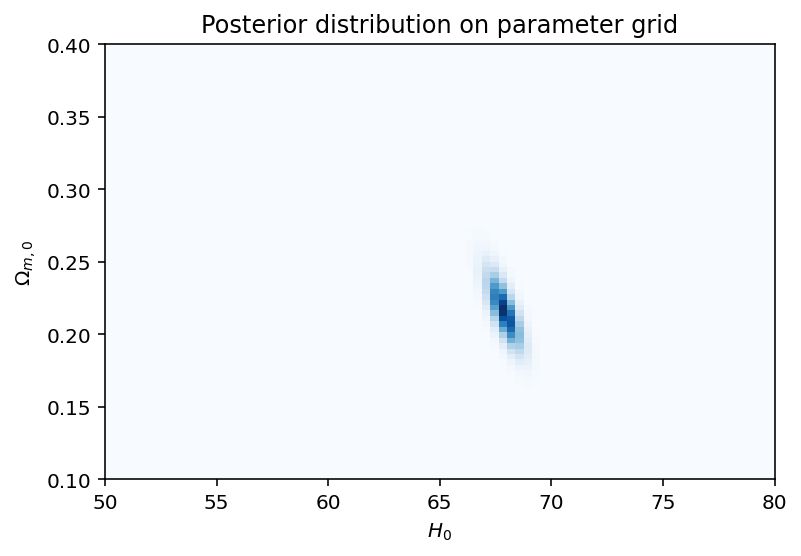

In [19]:
plt.imshow(post_grid, extent=(50., 80., 0.1, 0.4), origin='lower', aspect='auto', cmap='Blues')

plt.xlabel(r"$H_{0}$")
plt.ylabel(r"$\Omega_{m,0}$")
plt.title("Posterior distribution on parameter grid")

Looks reasonable! Why bother going on? 

While we can compute posterior PDFs on a grid in relatively low dimensions, the computational cost to do so increases exponentially: we'd need $\texttt{n_param}^\texttt{n_grid}$ evaluations. Even for the above case using `vmap`, we'll quickly run out of memory if we increase the grid sampling frequency of each parameter, and the situation is more hopeless still if we have more parameters.

## 4.&nbsp;Markov Chain Monte Carlo

Since the posterior is a probability distribution, we can draw samples from it. We sample from an unnormalized probability distribution function that is proportional to the posterior up to a constant,

$$ \mathrm{PDF} = p(x\mid\theta)\cdot p(\theta)\propto p(\theta\mid x)$$

with the samples then being representative of the joint posterior on the two parameters of interest.

We'll use a particular implementation of an MCMC algorithm (Affine Invariant Markov chain Monte Carlo) with [`emcee`](https://emcee.readthedocs.io/en/stable/).

In [20]:
import emcee
import corner

Run the sampler. Experiment with using running non-vectorized/vmapped versions of these functions to gain an idea of the kinds of speed-ups you can get.

In [21]:
n_walkers = 8

# Use the vectorized log-posterior PDF we coded up to parallelize over walkers
sampler = emcee.EnsembleSampler(nwalkers=n_walkers, ndim=2, log_prob_fn=log_post_vmap, args=(zs, mm, dm), vectorize=True)
pos = soln.x + 1e-2 * np.random.randn(n_walkers, 2)

sampler.run_mcmc(initial_state=pos, nsteps=4000, progress=True);

100%|██████████| 4000/4000 [00:12<00:00, 317.63it/s]


In [22]:
samples_emcee = sampler.get_chain(discard=500, thin=5, flat=True)

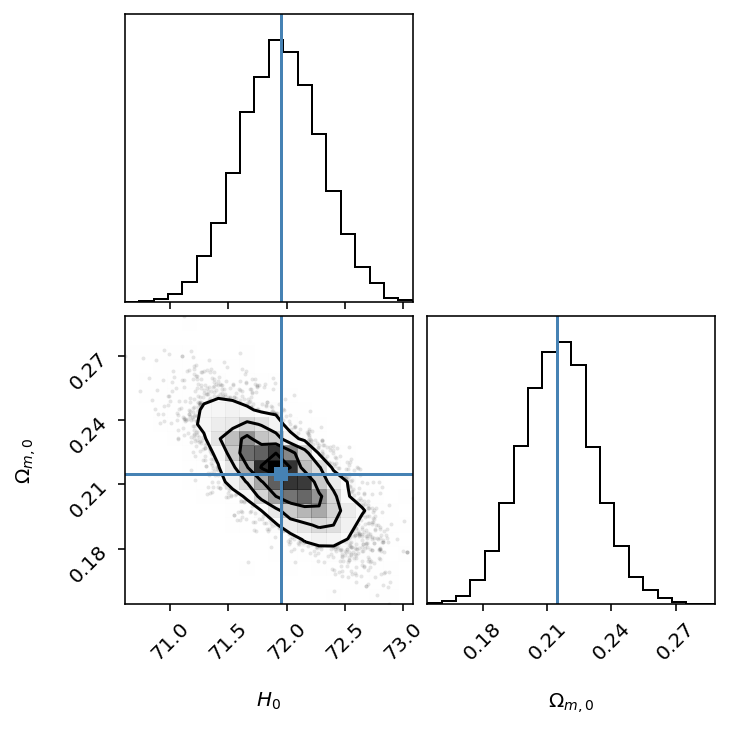

In [23]:
corner.corner(samples_emcee, truths=soln.x, labels=[r"$H_0$", r"$\Omega_{m,0}$"]);

## 5.&nbsp;Differentiable probabilistic programming approaches with NumPyro

In [24]:
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import SVI, Predictive, Trace_ELBO, autoguide
import numpyro.distributions as dist

from tqdm.notebook import tqdm

Now let's try our hand at the probabilistic programming approach. We will use a probabilistic programming language (PPL) framework called NumPyro, which derives from Jax. There are two parts to this whole thing:
1. _Define the model_;
2. _Perform inference on it_.

#### 5.1.&nbsp;Defining the model: probabilistic graphical models (PGMs)

In the probabilistic programming spirit, we will define our model as a probabilistic program which encodes the dependencies between random variables. A nice way to visualize complex models are _probabilistic graphical models_ (PGMs) which specify the conditional dependencies between variables, both modeled and observed. 

We will use [`daft`](https://docs.daft-pgm.org/en/latest/api/#the-pgm-object) to visualize our model using a PGM, below. The various probability distributions are represented in **red rectangles**, stochastic random variables in **black circles**, and _observed_ parameters in **double circles**. The conditional independence between a set of variables (here, $N$ different supernova observations) are indicated by placing these inside a large rectangle (called a _plate_).

/usr/local/lib/python3.7/dist-packages/daft.py:848: RuntimeWarning: divide by zero encountered in double_scalars
  dxx2 = self.scale * 0.5 * np.abs(dx / dy) * (np.sign(dx) or 1.0)
/usr/local/lib/python3.7/dist-packages/daft.py:843: RuntimeWarning: divide by zero encountered in double_scalars
  * (np.sign(dy) or 1.0)


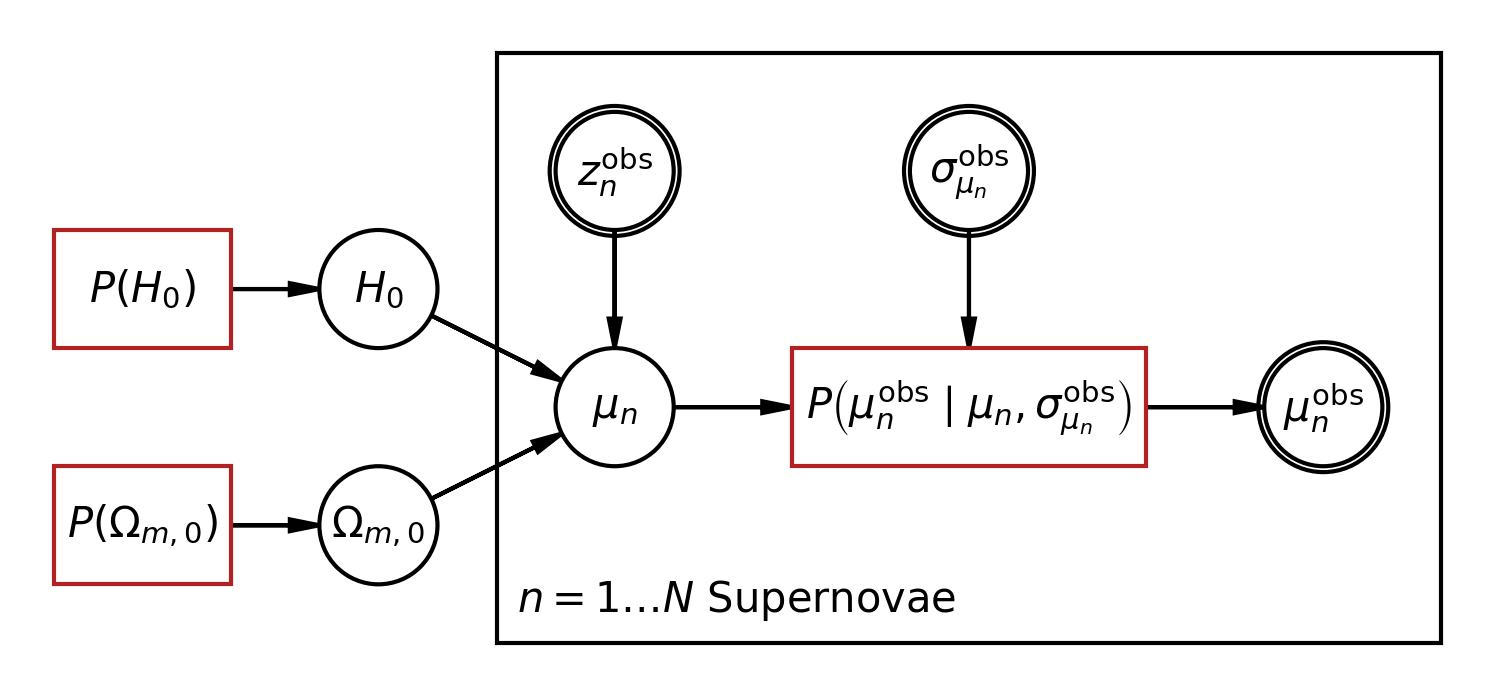

In [25]:
import daft

pgm = daft.PGM(observed_style="outer")

pgm.add_node("P(H_0)", r"$P(H_0)$", -1, 4, shape="rectangle", aspect=1.5, plot_params={"ec":color_default})
pgm.add_node("H_0", r"$H_0$", 0, 4)
pgm.add_node("obs", r"$\mu^{\mathrm{obs}}_n$", 4, 3.5, observed=True)
pgm.add_node("err", r"$\sigma_{\mu_n}^\mathrm{obs}$", 2.5, 4.5, observed=True)
pgm.add_node("z", r"$z_{n}^\mathrm{obs}$", 1, 4.5, observed=True)
pgm.add_node("P(\mu_n|\mu)", r"$P\left(\mu^{\mathrm{obs}}_n\mid \mu_n, \sigma_{\mu_n}^\mathrm{obs}\right)$", 2.5, 3.5, scale=1, aspect=3.0, shape="rectangle", plot_params={"ec":color_default})
pgm.add_node("\mu", r"$\mu_n$", 1, 3.5)

pgm.add_node("P(\Omega_{m,0})", r"$P(\Omega_{m,0})$", -1, 3, shape="rectangle", aspect=1.5, plot_params={"ec":color_default})
pgm.add_node("\Omega_{m,0}", r"$\Omega_{m,0}$", 0, 3)

pgm.add_plate([0.5, 2.5, 4, 2.5], label=r"$n=1\ldots N$ Supernovae")

pgm.add_edge("P(H_0)", "H_0")
pgm.add_edge("H_0", "\mu")
pgm.add_edge("\Omega_{m,0}", "\mu")
pgm.add_edge("z", "\mu")
pgm.add_edge("P(\Omega_{m,0})", "\Omega_{m,0}")
pgm.add_edge("P(\mu_n|\mu)", "obs")
pgm.add_edge("err", "P(\mu_n|\mu)")
pgm.add_edge("\mu", "P(\mu_n|\mu)")

pgm.render(dpi=150);

The relevant distributions are asssumed to be as follows:
$$P(H_0) = \mathcal{U}(10., 100.)$$
$$P(\Omega_{m,0}) = \mathcal{U}(0., 1.)$$
$$p(\mu_\mathrm{obs}\mid \mu_\mathrm{pred}) = \mathcal N(\mu_\mathrm{pred},\sigma_{\mu_\mathrm{obs}}; \mu_\mathrm{obs}).$$

Defining the model in NumPyro follows the above PGM closely
- Stochastic random variables are defined with `numpyro.sample(name, distribution)`
- Deterministic variables are specified with `numpyro.deterministic(name, expression)`
- Conditioning on observations is done using `numpyro.sample(name, distribution, obs=observation)`
- Independence between random variables (plating) is specified using `numpyro.plate`

In [26]:
def model(x, y, yerr):
    """ Model definition in NumPyro
    """
    
    # Stochastic nodes
    H0 = 100 * numpyro.sample("h0", dist.Uniform(0.1, 1.0))
    OmM0 = numpyro.sample("OmM0", dist.Uniform(0., 1.))
    
    # Deterministic node
    y_pred = numpyro.deterministic("y_pred", mu_pred_vmap(x, H0, OmM0) + 25.)
    
    # N different independent observations
    with numpyro.plate('observed_data', len(y)):
        return numpyro.sample("obs", dist.Normal(y_pred, yerr), obs=y)

Having defined the model, we can go on to perform inference on it. In an ideal world, we wouldn't have to think about this part at all---all of the "science" happens in the model definition (arguably). 

This is (unfortunately) not the case however---choosing how to do inference on complex, high-dimensional models can be hard! Here are some examples using what's built in in NumPyro:
- Hamiltonian Monte Carlo (HMC)
- Stochastic Variational Inference (SVI)

#### 5.2.&nbsp;Inference with Hamiltonian Monte Carlo (HMC)

- Markov Chain Monte Carlo (MCMC) algorithms let us sample from probability distributions---you've seen examples already and implemented the Metroplis-Hastings-[Rosenbluth](https://www.nytimes.com/2021/02/09/science/arianna-wright-dead.html) algorithm. Traditional MCMC algorithms can becomes increasingly inefficient when the parameter space of interest becomes high dimensional. 

- Hamiltonian Monte Carlo (HMC) is a variant of MCMC which uses likelihood _gradient_ information $\nabla_\theta\mathcal L$ in addition to the likelihood $\mathcal L$ and can scale much better to sampling from higher-dimensional distributions. Intuitively, it leverages the "momentum" of the likelihood function in addition to the "position".

- See [this page](https://chi-feng.github.io/mcmc-demo/app.html) for a cool demo and comparison of some sampling algorithms, including HMC and vanilla random walk Metropolis-Hastings.

In [27]:
from IPython.display import IFrame
IFrame('https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=donut', width=750, height=500)

Since we've written down our model in a differentiable framework, we can easily run HMC on it. Now we're getting into _differentiable_ probabilistic programming.

In [28]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=500)
rng_key = jax.random.PRNGKey(1)
mcmc.run(rng_key, zs, mm, dm)

sample: 100%|██████████| 4500/4500 [00:24<00:00, 182.91it/s, 7 steps of size 5.00e-01. acc. prob=0.93]


In [29]:
samples_hmc = {k: v for k, v in mcmc.get_samples().items()}
samples_hmc = np.array([samples_hmc['h0'] * 100, samples_hmc['OmM0']]).T

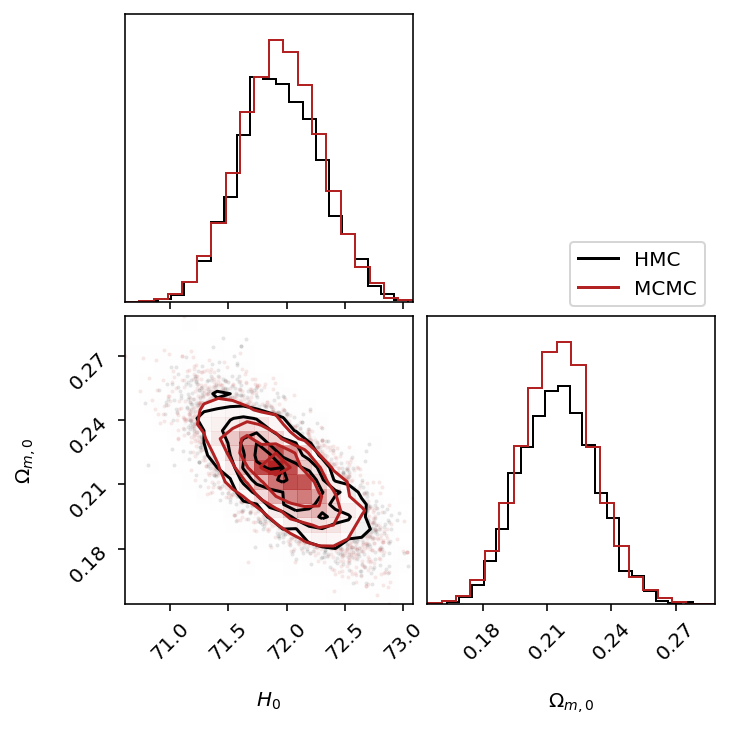

In [30]:
import matplotlib.lines

figure = corner.corner(samples_hmc, labels=[r"$H_0$", r"$\Omega_{m,0}$"])
corner.corner(samples_emcee, fig=figure,weights=np.ones(len(samples_emcee)) / (len(samples_emcee) / len(samples_hmc)), color=color_default);

red_line = matplotlib.lines.Line2D([], [], color='firebrick', label='MCMC')
black_line = matplotlib.lines.Line2D([], [], color='k', label='HMC')

plt.legend(handles=[black_line, red_line], bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

Pretty good!

#### 5.3.&nbsp;Inference with Stochastic Variational Inference (SVI)

Other than obtaining samples from the posterior of interest, another method for approximating posterior distributions is to **optimize over a family of functions (called the _variational family_) such that the inferred distribution closely matches the actual posterior.**

The name comes from the _calculus of variations_, where infinitesimal changes to functionals (functions of functions, colloquially) are studied.

- In contrast to the MCMC-style approaches, this turns posterior inference into an optimization problem, rather than a sampling problem. 
- In contrast to the MLE approach, rather than finding a single optimal set of parameter values (optimizing over possible numbers), we are now finding a single optimal _distribution_ (optimizing over possible functions).

Let's demonstrate this with plots, arbitrarily showing the "true" posterior as a t-distribution (just for schematic purposes).

In [31]:
from scipy.stats import t, norm

# "True" distribution, just for schematic purposes
x = np.linspace(66, 74, 200)
post_fake = t.pdf(x, df=2, loc=np.mean(samples_emcee[:, 0]), scale=np.std(samples_emcee[:, 0]))

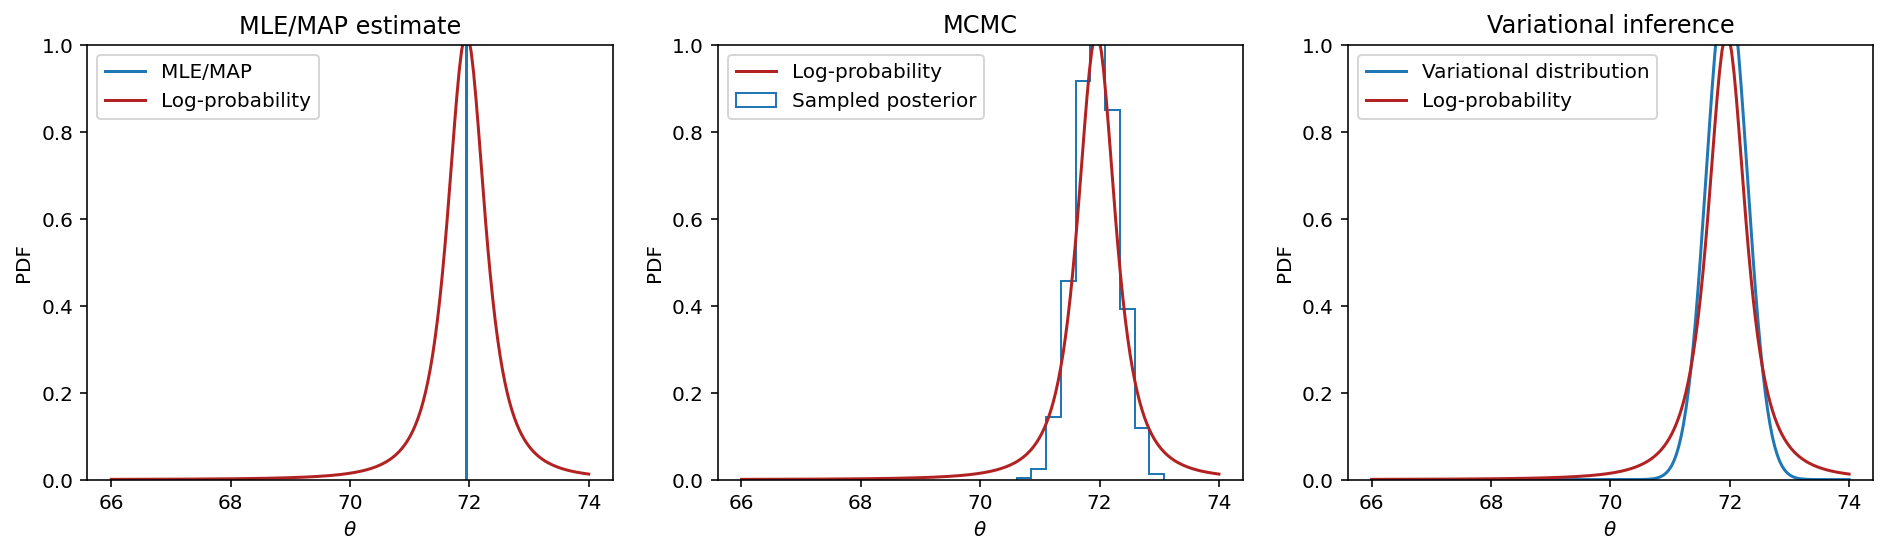

In [32]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16,4))

ax[0].axvline(soln.x[0], label="MLE/MAP")
ax[0].plot(x, post_fake, color=color_default, label="Log-probability")
ax[0].set_title("MLE/MAP estimate")

ax[1].hist(samples_emcee[:, 0], histtype='step', density=True, label="Sampled posterior")
ax[1].plot(x, post_fake, color=color_default, label="Log-probability")
ax[1].set_title("MCMC")

# Arbitrarily-defined Gaussian approximation for the posterior
post_approx = norm.pdf(x, loc=np.mean(samples_emcee[:, 0]), scale=np.std(samples_emcee[:, 0]))
ax[2].plot(x, post_approx, label="Variational distribution")
ax[2].plot(x, post_fake, color=color_default, label="Log-probability")
ax[2].set_title("Variational inference")

[ax[i].set_xlabel(r"$\theta$") for i in range(3)]
[ax[i].set_ylabel(r"PDF") for i in range(3)]
[ax[i].set_ylim(0, 1) for i in range(3)]
[ax[i].legend(loc='upper left') for i in range(3)]

Here, we can borrow many of the optimization tricks from deep learning and efficiently scale to much higher dimensions and more complex likelihoods than is possible with sampling algorithms. In _stochastic_ variational inference, we use stochastic gradient descent to optimize over the variational family and target our desired posterior distribution.

We minimize the KL-divergence (a particular measure of closeness between distributions, also known as the "relative entropy") to arrive at the distribution that approximates our posterior well:

$$D_{\mathrm{KL}}(P \| Q)=\int p(x) \log \left(\frac{p(x)}{q(x)}\right) d x$$

with the integral being over the support of $P$. Let's compute $D_{\mathrm{KL}}(P \| Q)$ for a few different Gaussians, again NumPyro is doing all of the heavy lifting:

In [33]:
p = numpyro.distributions.Normal(loc=1,scale=1)
q = numpyro.distributions.Normal(loc=1.2,scale=0.8)

kl = numpyro.distributions.kl.kl_divergence(p, q)

print("KL-divergence is {}".format(kl))

KL-divergence is 0.08935644868579024


In [34]:
p = numpyro.distributions.Normal(loc=1,scale=1)
q = numpyro.distributions.Normal(loc=2.2,scale=0.8)

kl = numpyro.distributions.kl.kl_divergence(p, q)

print("KL-divergence is {}".format(kl))

KL-divergence is 1.1831064486857907


How do we do this without already knowing the posterior? While we can't minimize the KL-divergence directly, we can optimize another function that's equal to it up to a constant, called the Evidence Lower BOund (ELBO). This is abstracted away in NumPyro and we won't go into details, but see [here](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf) or [here](https://mpatacchiola.github.io/blog/2021/01/25/intro-variational-inference.html) for details and a derivation of this objective function.

TODO: More theory about variational optimization, a manual example?

Now in addition to the model we need to define the variational family, in NumPyro parlance known as a _guide_. Let's start with something simple---two different Gaussian distributions modeling the posteriors of the two parameters $H_0$ and $\Omega_{m,0}$.

In [35]:
def guide(x, y, yerr):
    """ A variational distribution defined by two uncorrelated Gaussians
    """
    
    # Means and standard deviations of Gaussians
    locs = numpyro.param("loc", 0.5 * jnp.ones(2))
    scales = numpyro.param("scales", 0.01 * jnp.ones(2), constraint=dist.constraints.positive)
    
    # Parameter samples from variational distribution
    h0 = numpyro.sample("h0", dist.Normal(locs[0], scales[0],))
    OmM0 = numpyro.sample("OmM0", dist.Normal(locs[1], scales[1],))

Now we can use the NumPyro API to perform gradient descent on the guide parameters, in this case optimizing the means and stds of the two Gaussians.

In [36]:
optimizer = numpyro.optim.Adam(0.01)
svi = SVI(model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(1), 1500, zs, mm, dm)
params = svi_results.params

100%|██████████| 1500/1500 [00:02<00:00, 675.93it/s, init loss: 5150.8753, avg. loss [1426-1500]: -101.6983] 


After optimization, we can draw samples values from the guide to get a representative posterior. Note that since the modeled posterior in this case is quite simple (just two Gaussians) this could be done analytically. However in general for more complex variational posteriors and high-dimensional distributions we need to sample.

Let's plot the samples and compare with what we got from `emcee`:

In [37]:
from scipy.stats import norm

samples_svi = norm.rvs(svi_results.params['loc'], svi_results.params['scales'], size=(10000,2))
samples_svi[:, 0] *= 100.

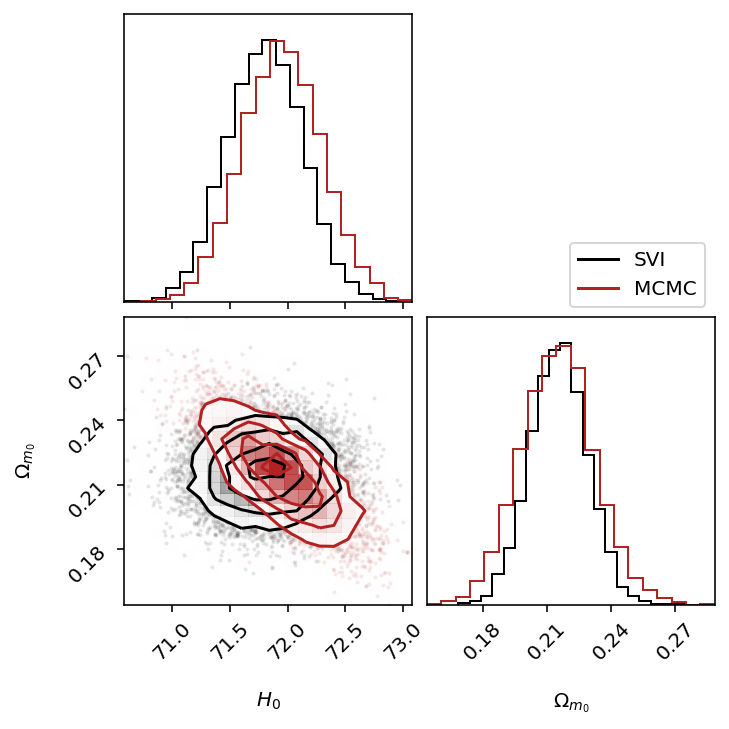

In [38]:
import matplotlib.lines

figure = corner.corner(samples_svi, labels=[r"$H_0$", r"$\Omega_{m_0}$"])
corner.corner(samples_emcee, fig=figure,weights=np.ones(len(samples_emcee)) / (len(samples_emcee) / len(samples_svi)), color=color_default);

red_line = matplotlib.lines.Line2D([], [], color='firebrick', label='MCMC')
black_line = matplotlib.lines.Line2D([], [], color='k', label='SVI')

plt.legend(handles=[black_line, red_line], bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

**It looks like the SVI approach doesn't do a great job at modeling the joint posterior, assuming the MCMC samples to be representative!** Not too surprising perhaps---our variational distribution totally ignored correlations between the two parameters, which clearly exist (the joint posterior is a diagonal ellipse, meaning there are degeneracies between parameters).

Fortunately, we can do better. NumPyro provides a nice interface for automatically generate variational distributions, called "autoguides". For example, we can use a multivariate normal distribution which additionally fits for the covariances between different parameters, as follows: 

In [39]:
# Define a guide
guide = autoguide.AutoMultivariateNormal(model)

Let's do the optimization again with this guide, draw some samples and plot them.

In [40]:
optimizer = numpyro.optim.Adam(0.01)
svi = SVI(model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(1), 1500, zs, mm, dm)
params = svi_results.params

100%|██████████| 1500/1500 [00:04<00:00, 344.99it/s, init loss: 527.2434, avg. loss [1426-1500]: -102.6790] 


In [41]:
samples_svi = guide.sample_posterior(rng_key=jax.random.PRNGKey(0), params=params, sample_shape=(10000,))
samples_svi = np.array([samples_svi['h0'] * 100, samples_svi['OmM0']]).T

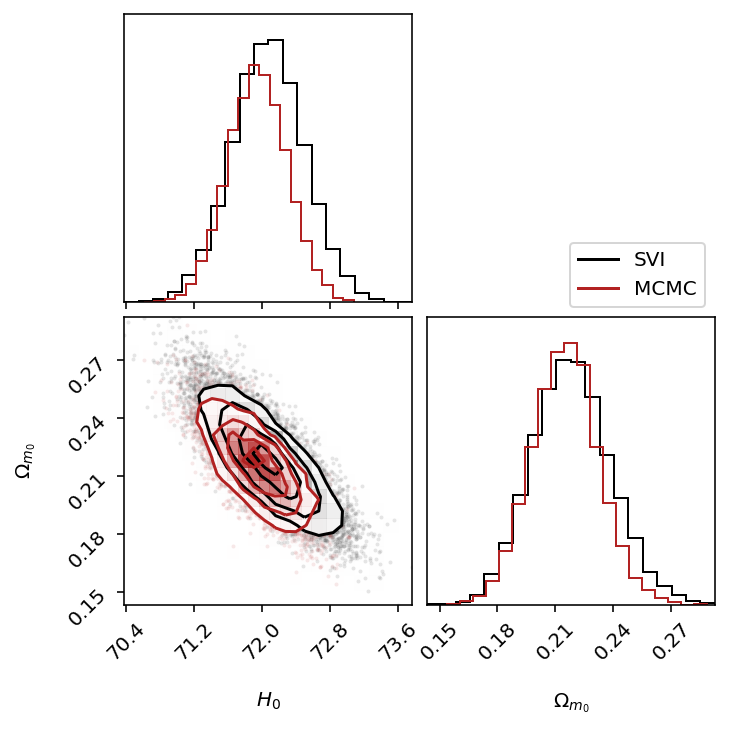

In [42]:
figure = corner.corner(samples_svi, labels=[r"$H_0$", r"$\Omega_{m_0}$"])
corner.corner(samples_emcee, fig=figure,weights=np.ones(len(samples_emcee)) / (len(samples_emcee) / len(samples_svi)), color=color_default);

red_line = matplotlib.lines.Line2D([], [], color='firebrick', label='MCMC')
black_line = matplotlib.lines.Line2D([], [], color='k', label='SVI')

plt.legend(handles=[black_line, red_line], bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

This time the joint posterior is much closer to the MCMC ones, and we can see the covariances between the two components in action.

TODO/Optional: More complex/flexible variational distributions